In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme("paper", "whitegrid")
import pyBigWig
import pickle
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from scipy.stats import mannwhitneyu
from sklearn.neighbors import KernelDensity

In [2]:
borders = [.28, .44, .92, .99]

In [3]:
def make_boundaries(x):
    if x[2] < .28:
        x[2] = -2
    elif x[2] < .44:
        x[2] = -1
    elif x[2] < .92:
        x[2] = 0
    elif x[2] < .99:
        x[2] = 1
    else:
        x[2] = 2
    return x

In [6]:
entropy = pyBigWig.open("../data/InformME/human colon normal METH NME ENTR MML VAR/ENTR-colon_normal-filled.bw")

classification = pyBigWig.open("../data/entropy_blocks.bw", "w")

In [7]:
header = list(entropy.chroms().items())

In [8]:
classification.addHeader(header)

In [9]:
for chr in tqdm(entropy.chroms()):
    intervals = np.array(entropy.intervals(chr))
    block_boundaries = intervals
    block_boundaries = np.apply_along_axis(make_boundaries, 1, block_boundaries)
    classification.addEntries([chr] * block_boundaries.shape[0], 
                              block_boundaries[:, 0].astype(int).tolist(), 
                              block_boundaries[:, 1].astype(int).tolist(), 
                              block_boundaries[:, 2].tolist())

classification.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:01<00:00,  2.80s/it]


# Looking at the data

In [11]:
names = ["METH", "MML", "NME", "VAR"]

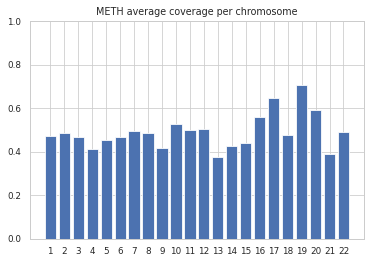

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:50<00:00,  2.30s/it]


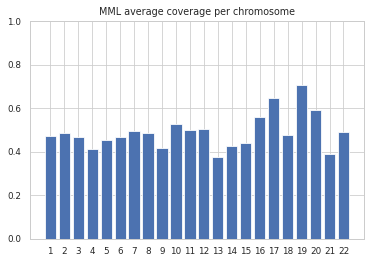

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]


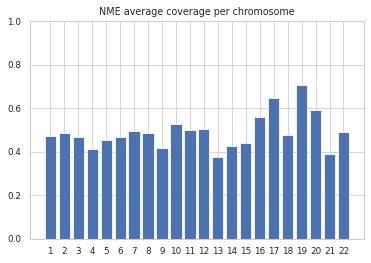

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:04<00:00,  2.92s/it]


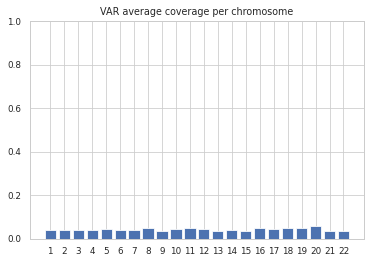

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.01s/it]


In [13]:
for name in names:
    entropy = pyBigWig.open(f"../data/InformME/human colon normal METH NME ENTR MML VAR/{name}-colon_normal.bw")

    coverage = np.array([entropy.stats("chr" + str(i), type="coverage") for i in range(1, 23)]).reshape(-1,)
    plt.bar(np.arange(1, 23), coverage)
    plt.grid(.3, axis="y")
    plt.xticks(np.arange(1, 23))
    plt.ylim(0, 1)
    plt.title(f"{name} average coverage per chromosome")
    plt.show()
#     plt.tight_layout()
#     plt.savefig("{} average coverage per chromosome".format(name), dpi=200)

    window_size = 10000
    averaged = pyBigWig.open(f"../data/output/human_averaged/{name}_averaged{window_size}.bw", "w")
    averaged.addHeader(list(entropy.chroms().items()))

    for chr_name in tqdm(entropy.chroms().keys()):
        chr_len = entropy.chroms()[chr_name]
        means = entropy.stats(chr_name, nBins=chr_len // window_size)
        means = np.array(means)
        starts = np.arange(0, chr_len - window_size, window_size)
        starts = starts[means != None]
        means = means[means != None]
        averaged.addEntries(chr_name, starts, values=means.astype(float), span=window_size)
    averaged.close()

# Making blocks in the way the paper suggests

In [36]:
entropy = pyBigWig.open("../data/InformME/human colon normal METH NME ENTR MML VAR/ENTR-colon_normal.bw")

In [37]:
classification_file = pyBigWig.open("../data/output/entropy_blocks/entropy_blocks_500000_all_chroms.bw", "w")
classification_file.addHeader(list(entropy.chroms().items()))

In [38]:
for chr in entropy.chroms():
    entropy_intervals = entropy.intervals(chr)

    START = entropy_intervals[0][0]
    FINISH = entropy_intervals[-2][0]
    
    window_start = START
    window_end = START
    LEN_WINDOW = 500000 // 150
    ordered = 0
    disordered = 0
    weakly = 0
    for j in range(LEN_WINDOW):
        value = entropy.values(chr, window_end, window_end + 1)[0]
        if value == 1:
            ordered += 1
        elif value == -1:
            disordered += 1
        elif value == 0:
            weakly += 1
        window_end += 150

    clf = dict()
    for window_start in tqdm(range(START, FINISH - 1, 150)):
        clf[window_start] = [0, 0, 0]
        if 4 * ordered >= 3 * (ordered + disordered):
            clf[window_start][2] = 1
        elif 4 * disordered >= 3 * (ordered + disordered):
            clf[window_start][1] = 1
        else:
            clf[window_start][0] = 1

        old_start_value = entropy.values(chr, window_start, window_start + 1)[0]
        if old_start_value == 1:
            ordered -= 1
        elif old_start_value == -1:
            disordered -= 1
        elif old_start_value == 0:
            weakly -= 1
        
        try:
            new_end_value = entropy.values(chr, window_end, window_end + 1)[0]
            if new_end_value == 1:
                ordered += 1
            elif new_end_value == -1:
                disordered += 1
            elif new_end_value == 0:
                weakly += 1
            window_end += 150
        except:
            pass

    regions = []
    curr_start = START
    curr_state = 1
    curr_end = curr_start 
    for window_start, clf_res in clf.items():    
        if np.array(clf_res).argmax() != 0 and np.array(clf_res).argmax() != curr_state:
            regions.append((curr_start, curr_end, curr_state))
            curr_start = window_start
            curr_state = np.array(clf_res).argmax()
        curr_end = window_start

    block_boundaries = np.array(regions)[1:]
    block_boundaries[:, 2] = block_boundaries[:, 2] * 2 - 3
    classification_file.addEntries(
        [chr] * block_boundaries.shape[0], 
        block_boundaries[:, 0].astype(int).tolist(), 
        block_boundaries[:, 1].astype(int).tolist(), 
        block_boundaries[:, 2].astype(float).tolist()
    )

classification_file.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 940629/940629 [02:25<00:00, 6475.82it/s]


In [ ]:
classification_file.close()

# Distribution of inter-tad spaces

In [37]:
from sklearn.neighbors import KernelDensity

In [38]:
to_plot = []
log_densities_spaces = []
log_densities_lengths = []
names = ["h1", "imr90"]
reps = ["combined", "rep1", "rep2"]
path_to_tads = "../data/input/tad_boundaries_hESC_IMR90_hg19"
for name in names:
    for rep in reps:
        tad_boundaries = list(map(lambda x: x.split(), open(f"{path_to_tads}/{name}.{rep}.bed").readlines()))
        tad_boundaries = np.array(tad_boundaries)
        spaces = []
        lengths = []
        for chr in range(1, 23):
            tad_boundaries_chr = tad_boundaries[tad_boundaries[:, 0] == "chr{}".format(chr)]
            tad_boundaries_chr = tad_boundaries_chr[:, 1:].astype(int)
            tad_boundaries_chr.shape
            spaces.append(tad_boundaries_chr[1:, 0] - tad_boundaries_chr[:-1, 1])
            lengths.append(tad_boundaries_chr[:, 1] - tad_boundaries_chr[:, 0])
        spaces = np.concatenate(spaces).reshape(-1, 1)
        lengths = np.concatenate(lengths).reshape(-1, 1)
        
        kde = KernelDensity(kernel="gaussian", bandwidth=40000).fit(spaces)
        log_densities = kde.score_samples(np.arange(0, 4e6, 1e3).reshape(-1, 1))
        log_densities_spaces.append(log_densities)
        
        kde = KernelDensity(kernel="gaussian", bandwidth=40000).fit(lengths)
        log_densities = kde.score_samples(np.arange(0, 4e6, 1e3).reshape(-1, 1))
        log_densities_lengths.append(log_densities)

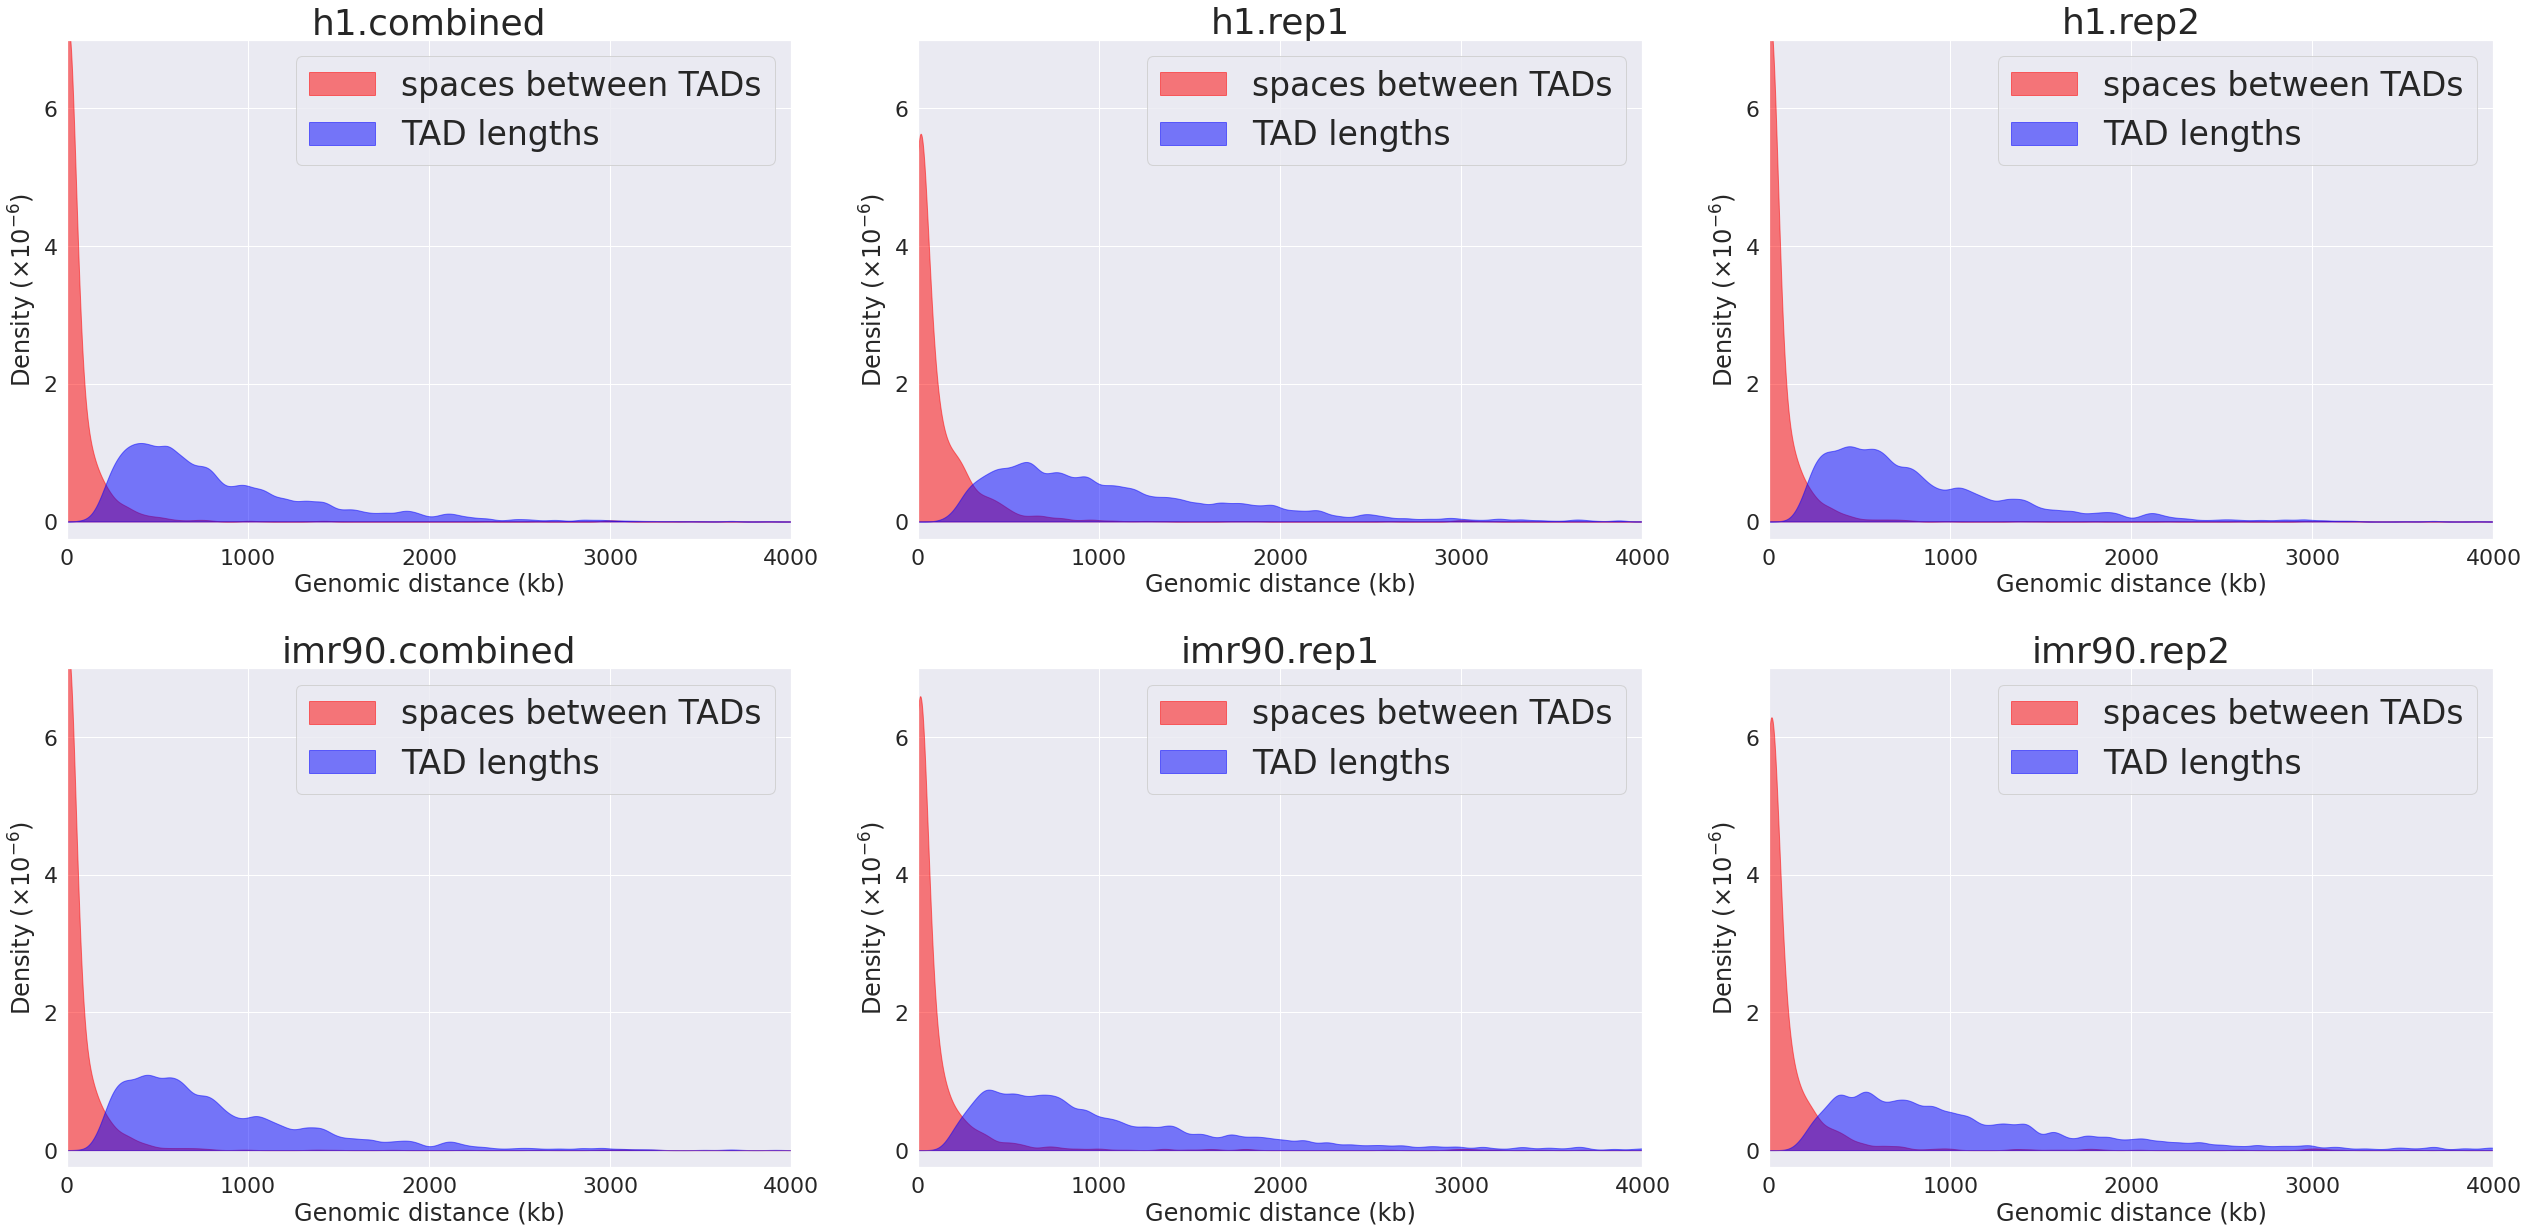

In [57]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(3*12, 2*9))
sns.set()
sns.set(font_scale=3)
for i in range(2):
    for j in range(3):
        ax[i][j].fill_between(np.arange(0, 4e6, 1e3), 
                              np.exp(log_densities_spaces[i * 2 + j]), 
                              alpha=.5, 
                              color="red",
                              label="spaces between TADs"
                             )
        ax[i][j].fill_between(np.arange(0, 4e6, 1e3), 
                              np.exp(log_densities_lengths[i * 2 + j]), 
                              alpha=.5, 
                              color="blue",
                              label="TAD lengths"
                             )
        ax[i][j].set_title("{}.{}".format(names[i], reps[j]))
        ax[i][j].set_ylim(-0.25 * 1e-6, 7 * 1e-6)
        ax[i][j].set_xlim(0, 4000000)
        ax[i][j].set_xlabel("Genomic distance (kb)")
        ax[i][j].set_ylabel(r"Density $( \times 10^{-6})$")
        ax[i][j].set_xticks([0, 1e6, 2e6, 3e6, 4e6]) 
        ax[i][j].set_xticklabels([0, 1000, 2000, 3000, 4000])
        ax[i][j].set_yticks([0, 2e-6, 4e-6, 6e-6])
        ax[i][j].set_yticklabels([0, 2, 4, 6])
        ax[i][j].legend()
plt.tight_layout()
# plt.savefig("gaps_and_lengths.jpg", dpi=200)
plt.show()

# Combining all tads and plotting the mistakes according to the paper

In [4]:
classification_file = pyBigWig.open("../data/output/entropy_blocks/entropy_blocks_500000_all_chroms.bw")

In [5]:
tad_boundaries_set = set()
path_to_tads = "../data/input/tad_boundaries_hESC_IMR90_hg19"

for name in ["h1", "imr90"]:
    for rep in ["combined", "rep1", "rep2"]:
        tad_boundaries_file = open(f"{path_to_tads}/{name}.{rep}.bed").readlines()
        tad_boundaries = list(map(lambda x: x.split(), open(f"{path_to_tads}/{name}.{rep}.bed").readlines()))
        
        tad_boundaries_set |= set(tad_boundaries_file)

        tad_edges_set = [set() for i in range(23)]
        tad_lengths = []
        for line in tad_boundaries_set:
            chr, beg, end = line.split()
            if "X" not in chr and "Y" not in chr:
                chr = int(chr[3:])
                tad_edges_set[chr].add(int(beg))
                tad_edges_set[chr].add(int(end))
                tad_lengths.append(int(end) - int(beg))

In [6]:
np.array([len(tad_edges_set[i]) for i in range(1, 10)]).sum()

5182

In [7]:
for i in range(1, len(tad_edges_set)):
    tad_edges_set[i] = list(tad_edges_set[i])

In [8]:
mistakes = []
for i in range(1, 10):
    regions = np.array(classification_file.intervals("chr" + str(i)))
    for j in regions[:, 1]:
        mistakes.append(np.abs(tad_edges_set[i] - j).min())

In [ ]:
tad_lengths = np.array(tad_lengths).reshape(-1, 1)

In [10]:
x_grid = np.arange(0, 4e6, 1e3).reshape(-1, 1)

In [11]:
kde = KernelDensity(kernel="gaussian", bandwidth=40000)
kde.fit(tad_lengths)
log_densisites = kde.score_samples(x_grid)

kde.fit(np.array(mistakes).reshape(-1, 1))
log_densisites_mistakes = kde.score_samples(x_grid)

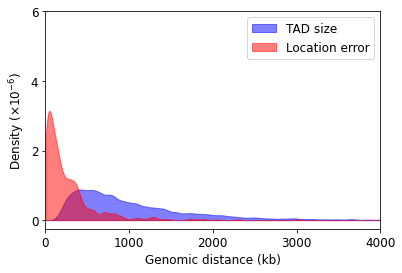

In [14]:
plt.rcParams.update({'font.size': 12})

plt.fill_between(
    x_grid.ravel(),
    np.exp(log_densisites),
    alpha=.5,
    label="TAD size",
    color="blue"
)
plt.fill_between(
    x_grid.ravel(),
    np.exp(log_densisites_mistakes),
    alpha=.5,
    label="Location error",
    color="red"
)
plt.ylim(-0.25 * 1e-6, 6 * 1e-6)
plt.xlim(0, 4000000)
plt.xlabel("Genomic distance (kb)")
plt.ylabel(r"Density $( \times 10^{-6})$")
plt.xticks([0, 1e6, 2e6, 3e6, 4e6], [0, 1000, 2000, 3000, 4000])
plt.yticks([0, 2e-6, 4e-6, 6e-6], [0, 2, 4, 6])
plt.legend()
plt.show()
# plt.tight_layout()
# plt.savefig("sizes_errors.pdf")

In [15]:
np.quantile(tad_lengths, 0.25)

520000.0

In [16]:
(np.array(mistakes) < 520000).mean()

0.8683127572016461

# Visual similarity between entropy blocks and TADs according to paper

In [39]:
classification_file = pyBigWig.open("../data/output/entropy_blocks/entropy_blocks_500000_all_chroms.bw")
intervals = np.array(classification_file.intervals("chr7"))
first_chromosome_tad_edges = np.array(tad_edges_set[7])

In [40]:
start = 20e6
finish = 45e6
intervals = intervals[intervals[:, 1] > start]
intervals = intervals[intervals[:, 0] < finish]
first_chromosome_tad_edges = first_chromosome_tad_edges[first_chromosome_tad_edges > start]
first_chromosome_tad_edges = first_chromosome_tad_edges[first_chromosome_tad_edges < finish]

In [41]:
ordered = intervals[intervals[:, 2] == 1]
disordered = intervals[intervals[:, 2] == -1]

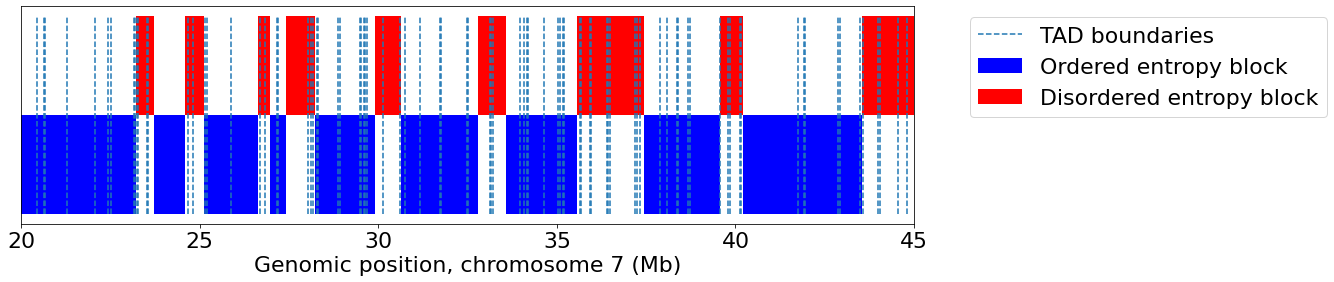

In [43]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16, 4))
plt.vlines(first_chromosome_tad_edges, -1, 1, linestyles="dashed", label="TAD boundaries")
# plt.bar(intervals[:, 0], intervals[:, 2], intervals[:, 1] - intervals[:, 0], align="edge")

plt.bar(
    ordered[:, 0],
    -1, 
    ordered[:, 1] - ordered[:, 0],
    align="edge",
    color="blue",
    label="Ordered entropy block"
)

plt.bar(
    disordered[:, 0],
    1,
    disordered[:, 1] - disordered[:, 0],
    align="edge",
    color="red",
    label="Disordered entropy block"
)

plt.yticks([])
plt.xticks(np.linspace(2, 4.5, 6) * 1e7, np.arange(20, 50, 5))
plt.xlabel("Genomic position, chromosome 7 (Mb)")
plt.xlim(start, finish)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# plt.tight_layout()
# plt.savefig("similarity.pdf")